# E-Ticaret Lojistik Verileri ile Teslimat Tahmini
## Veri Bilimine Giriş ve Makine Öğrenmesi Uygulaması

---

**Veri Seti:** Christmas Retail Sales – Shipping & Delivery Dataset (Kaggle)

**Amaç:** Bu çalışmada, e-ticaret lojistik verileri üzerinde veri biliminin temel adımlarını uygulayarak, teslimat durumunu (geç/zamanında) tahmin eden bir makine öğrenmesi modeli geliştireceğiz.

---

## 1. Kütüphanelerin Yüklenmesi

Veri analizi ve görselleştirme için gerekli Python kütüphanelerini import ediyoruz.

In [9]:
# Temel veri işleme kütüphaneleri
import pandas as pd
import numpy as np

# Görselleştirme kütüphaneleri
import matplotlib.pyplot as plt
import seaborn as sns

# Makine öğrenmesi kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Uyarıları kapatıyoruz (daha temiz çıktı için)
import warnings
warnings.filterwarnings('ignore')

# Grafik ayarları
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


---

## 2. Veri Tanıma

### 2.1 Veri Setinin Genel Amacı

Bu veri seti, Black Friday, Cyber Monday ve Noel dönemlerindeki perakende satış verilerini içermektedir. Sipariş, ürün, kampanya, sevkiyat, teslimat, iade ve takvim bilgilerini kapsayan çok tablolu bir yapıya sahiptir.

### 2.2 Tabloların Yüklenmesi

Excel dosyasındaki tüm tabloları (sheet'leri) yükleyerek inceliyoruz.

In [10]:
# Excel dosyasının yolu
dosya_yolu = "Christmas_Retail_Sales_and_Marketing_Analysis_Dataset.xlsx"

# Excel dosyasındaki tüm sheet isimlerini okuyalım
excel_dosyasi = pd.ExcelFile(dosya_yolu)
tablo_isimleri = excel_dosyasi.sheet_names

print("Veri setindeki tablolar:")
print("-" * 40)
for i, tablo in enumerate(tablo_isimleri, 1):
    print(f"{i}. {tablo}")

Veri setindeki tablolar:
----------------------------------------
1. OrderLine
2. Product
3. Promotion
4. Returns
5. Calendar
6. Fulfillment
7. OrderHeader


In [11]:
# Her tabloyu ayrı ayrı DataFrame olarak yükleyelim
tablolar = {}
for tablo_ismi in tablo_isimleri:
    tablolar[tablo_ismi] = pd.read_excel(dosya_yolu, sheet_name=tablo_ismi)

# Kolay erişim için değişkenlere atayalım
order_header = tablolar.get('OrderHeader', tablolar.get('Order Header', None))
order_line = tablolar.get('OrderLine', tablolar.get('Order Line', None))
product = tablolar.get('Product', None)
promotion = tablolar.get('Promotion', None)
fulfillment = tablolar.get('Fulfillment', None)
returns = tablolar.get('Returns', None)
calendar = tablolar.get('Calendar', None)

print("Tablolar başarıyla yüklendi!")

Tablolar başarıyla yüklendi!


### 2.3 Tabloların İş Sürecindeki Rolü

| Tablo | Açıklama |
|-------|----------|
| **OrderHeader** | Sipariş başlık bilgileri (müşteri, tarih, toplam tutar) |
| **OrderLine** | Sipariş satır detayları (ürün, miktar, fiyat) |
| **Product** | Ürün bilgileri (kategori, marka, fiyat) |
| **Promotion** | Kampanya ve indirim bilgileri |
| **Fulfillment** | Sevkiyat ve teslimat bilgileri (kargo, teslimat durumu) |
| **Returns** | İade bilgileri |
| **Calendar** | Tarih boyutu (tatiller, haftasonları) |

In [12]:
# Her tablonun satır ve sütun sayılarını gösterelim
print("Tabloların Boyutları")
print("=" * 50)
print(f"{'Tablo':<20} {'Satır':<10} {'Sütun':<10}")
print("-" * 50)

for isim, tablo in tablolar.items():
    satir, sutun = tablo.shape
    print(f"{isim:<20} {satir:<10} {sutun:<10}")

Tabloların Boyutları
Tablo                Satır      Sütun     
--------------------------------------------------
OrderLine            182138     8         
Product              4000       7         
Promotion            60         9         
Returns              21709      9         
Calendar             66         6         
Fulfillment          45000      10        
OrderHeader          45000      8         


### 2.4 Tabloların İlk Bakışı

Her tablonun ilk birkaç satırına ve yapısına göz atalım.

In [13]:
# Fulfillment tablosu - Ana odak noktamız (teslimat bilgileri)
print("FULFILLMENT TABLOSU (Sevkiyat/Teslimat Bilgileri)")
print("=" * 60)
if fulfillment is not None:
    display(fulfillment.head())
    print("\nSütun bilgileri:")
    print(fulfillment.dtypes)
else:
    print("Fulfillment tablosu bulunamadı.")

FULFILLMENT TABLOSU (Sevkiyat/Teslimat Bilgileri)


,ShipmentID,OrderID,WarehouseID,Carrier,ServiceLevel,PromisedDate,ShipDate,DeliveryDate,ShipCost$,DeliveryStatus
0,SH000001,O000001,W04,FedEx,Std,2025-11-09,2025-11-05,2025-11-10,5.08,Late
1,SH000002,O000002,W03,UPS,Std,2025-11-30,2025-11-27,2025-12-01,8.00,Late
2,SH000003,O000003,W04,UPS,Std,2025-12-06,2025-12-03,2025-12-09,8.22,Late
3,SH000004,O000004,W01,USPS,Std,2025-12-21,2025-12-18,2025-12-25,7.97,Late
4,SH000005,O000005,W01,DHL,Std,2025-11-07,2025-11-02,2025-11-08,11.09,Late



Sütun bilgileri:
ShipmentID         object
OrderID            object
WarehouseID        object
Carrier            object
ServiceLevel       object
PromisedDate       object
ShipDate           object
DeliveryDate       object
ShipCost$         float64
DeliveryStatus     object
dtype: object


In [14]:
# OrderHeader tablosu
print("ORDER HEADER TABLOSU (Sipariş Başlık Bilgileri)")
print("=" * 60)
if order_header is not None:
    display(order_header.head())
else:
    print("OrderHeader tablosu bulunamadı.")

ORDER HEADER TABLOSU (Sipariş Başlık Bilgileri)


,OrderID,OrderDateTime,CustomerID,ChannelID,StoreID,PromotionID,CouponCode,PaymentType
0,O000001,2025-11-04 14:19:00,C015001,STORE,S060,PR041,BF25,Card
1,O000002,2025-11-25 02:54:00,C024674,WEB,NaN,PR040,NaN,PayPal
2,O000003,2025-12-01 23:47:00,C002255,WEB,NaN,NaN,NaN,Card
3,O000004,2025-12-16 23:50:00,C007868,WEB,NaN,PR023,SAVE10,Card
4,O000005,2025-11-02 14:04:00,C005260,WEB,NaN,PR059,NaN,Card


In [15]:
# OrderLine tablosu
print("ORDER LINE TABLOSU (Sipariş Satır Detayları)")
print("=" * 60)
if order_line is not None:
    display(order_line.head())
else:
    print("OrderLine tablosu bulunamadı.")

ORDER LINE TABLOSU (Sipariş Satır Detayları)


,OrderLineID,OrderID,ProductID,Qty,UnitPrice,LineDiscount$,LineCost$,LineRevenue$
0,OL0000001,O000001,P001689,2,323.19,45.22,363.40,601.16
1,OL0000002,O000001,P000676,3,34.66,7.27,59.13,96.71
2,OL0000003,O000001,P000972,1,76.08,5.32,45.59,70.76
3,OL0000004,O000001,P001872,3,45.45,9.54,93.42,126.81
4,OL0000005,O000001,P001669,1,78.55,5.50,50.67,73.05


In [16]:
# Product tablosu
print("PRODUCT TABLOSU (Ürün Bilgileri)")
print("=" * 60)
if product is not None:
    display(product.head())
else:
    print("Product tablosu bulunamadı.")

PRODUCT TABLOSU (Ürün Bilgileri)


,ProductID,Category,Subcategory,StandardCost,MSRP,Vendor,SeasonalityTag
0,P000001,Sports,Cycling,154.81,241.95,VendorD,Winter
1,P000002,Books,Non-Fiction,5.42,10.36,VendorD,Evergreen
2,P000003,Beauty,Cosmetics,40.70,69.24,VendorA,Winter
3,P000004,Books,Children,31.79,52.81,VendorC,Giftable
4,P000005,Electronics,Gaming,71.59,110.37,VendorC,Winter


In [17]:
# Diğer tabloları da gösterelim
for isim in ['Promotion', 'Returns', 'Calendar']:
    tablo = tablolar.get(isim)
    if tablo is not None:
        print(f"\n{isim.upper()} TABLOSU")
        print("=" * 60)
        display(tablo.head(3))


PROMOTION TABLOSU


,PromotionID,Name,CampaignType,StartDate,EndDate,TargetSegment,DiscountType,PlannedLift%,PlannedBudget
0,PR001,BF-PR001,BF,2025-12-02,2025-12-09,New Customers,Percent,24.1,981583.96
1,PR002,Holiday-PR002,Holiday,2025-12-02,2025-12-05,Loyalty,Percent,40.5,892678.22
2,PR003,BF-PR003,BF,2025-12-18,2025-12-28,Returning Customers,Price,42.0,1025388.49



RETURNS TABLOSU


,ReturnID,OrderLineID,ReturnDate,ReasonCode,Condition,Refund$,RestockFee$,ReturnShipCost$,Disposition
0,R0000001,OL0000001,2025-11-16,Changed Mind,Damaged,589.19,4.51,7.46,Write-off
1,R0000002,OL0000003,2025-12-09,Defective,New,61.41,8.96,0.39,Resell
2,R0000003,OL0000008,2025-12-11,Changed Mind,Opened,200.27,3.72,2.20,Write-off



CALENDAR TABLOSU


,DateKey,Date,Week,FiscalMonth,HolidayFlag,EventName
0,20251101,2025-11-01,44,FY25-11,N,NaN
1,20251102,2025-11-02,44,FY25-11,N,NaN
2,20251103,2025-11-03,45,FY25-11,N,NaN


---

## 3. Veri Ön İşleme

Bu bölümde verilerimizi analiz ve modelleme için hazır hale getiriyoruz.

### 3.1 Veri Tiplerinin Kontrolü

In [18]:
# Fulfillment tablosunun detaylı bilgisi
print("Fulfillment Tablosu - Veri Tipleri ve Eksik Değerler")
print("=" * 60)
if fulfillment is not None:
    print(fulfillment.info())
    print("\n")
    print("Eksik değer sayıları:")
    print(fulfillment.isnull().sum())

Fulfillment Tablosu - Veri Tipleri ve Eksik Değerler
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ShipmentID      45000 non-null  object 
 1   OrderID         45000 non-null  object 
 2   WarehouseID     45000 non-null  object 
 3   Carrier         45000 non-null  object 
 4   ServiceLevel    45000 non-null  object 
 5   PromisedDate    45000 non-null  object 
 6   ShipDate        45000 non-null  object 
 7   DeliveryDate    45000 non-null  object 
 8   ShipCost$       45000 non-null  float64
 9   DeliveryStatus  45000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 3.4+ MB
None


Eksik değer sayıları:
ShipmentID        0
OrderID           0
WarehouseID       0
Carrier           0
ServiceLevel      0
PromisedDate      0
ShipDate          0
DeliveryDate      0
ShipCost$         0
DeliveryStatus    0
dtype: int64


### 3.2 Tarih Alanlarının Datetime Formatına Dönüştürülmesi

In [19]:
# Fulfillment tablosundaki tarih sütunlarını tespit edelim
if fulfillment is not None:
    # Olası tarih sütunları
    tarih_sutunlari = [col for col in fulfillment.columns if 'Date' in col or 'date' in col]
    print("Tespit edilen tarih sütunları:", tarih_sutunlari)
    
    # Tarih sütunlarını datetime formatına çevirelim
    for sutun in tarih_sutunlari:
        if sutun in fulfillment.columns:
            fulfillment[sutun] = pd.to_datetime(fulfillment[sutun], errors='coerce')
            print(f"'{sutun}' sütunu datetime formatına dönüştürüldü.")
    
    print("\nGüncellenmiş veri tipleri:")
    print(fulfillment.dtypes)

Tespit edilen tarih sütunları: ['PromisedDate', 'ShipDate', 'DeliveryDate']
'PromisedDate' sütunu datetime formatına dönüştürüldü.
'ShipDate' sütunu datetime formatına dönüştürüldü.
'DeliveryDate' sütunu datetime formatına dönüştürüldü.

Güncellenmiş veri tipleri:
ShipmentID                object
OrderID                   object
WarehouseID               object
Carrier                   object
ServiceLevel              object
PromisedDate      datetime64[ns]
ShipDate          datetime64[ns]
DeliveryDate      datetime64[ns]
ShipCost$                float64
DeliveryStatus            object
dtype: object


### 3.3 Tabloların Birleştirilmesi (Merge)

Analiz için gerekli tabloları ortak anahtarlar üzerinden birleştiriyoruz.

In [20]:
# Önce mevcut sütun isimlerini kontrol edelim
print("Fulfillment sütunları:", fulfillment.columns.tolist() if fulfillment is not None else "Yok")
print("\nOrderHeader sütunları:", order_header.columns.tolist() if order_header is not None else "Yok")
print("\nOrderLine sütunları:", order_line.columns.tolist() if order_line is not None else "Yok")

Fulfillment sütunları: ['ShipmentID', 'OrderID', 'WarehouseID', 'Carrier', 'ServiceLevel', 'PromisedDate', 'ShipDate', 'DeliveryDate', 'ShipCost$', 'DeliveryStatus']

OrderHeader sütunları: ['OrderID', 'OrderDateTime', 'CustomerID', 'ChannelID', 'StoreID', 'PromotionID', 'CouponCode', 'PaymentType']

OrderLine sütunları: ['OrderLineID', 'OrderID', 'ProductID', 'Qty', 'UnitPrice', 'LineDiscount$', 'LineCost$', 'LineRevenue$']


In [21]:
# Ana veri setimizi oluşturalım
# Fulfillment tablosu ana tablomuz olacak çünkü teslimat durumu burada

df = fulfillment.copy()

# OrderHeader ile birleştirme (eğer ortak anahtar varsa)
if order_header is not None:
    # Ortak sütunu bulalım
    ortak_sutunlar = set(df.columns) & set(order_header.columns)
    print(f"Fulfillment ve OrderHeader ortak sütunları: {ortak_sutunlar}")
    
    # OrderID veya benzeri bir anahtar varsa birleştirelim
    for anahtar in ['OrderID', 'Order ID', 'OrderId', 'order_id']:
        if anahtar in df.columns and anahtar in order_header.columns:
            df = df.merge(order_header, on=anahtar, how='left', suffixes=('', '_order'))
            print(f"OrderHeader tablosu '{anahtar}' üzerinden birleştirildi.")
            break

print(f"\nBirleştirilmiş veri seti boyutu: {df.shape}")
print(f"Sütunlar: {df.columns.tolist()}")

Fulfillment ve OrderHeader ortak sütunları: {'OrderID'}
OrderHeader tablosu 'OrderID' üzerinden birleştirildi.

Birleştirilmiş veri seti boyutu: (45000, 17)
Sütunlar: ['ShipmentID', 'OrderID', 'WarehouseID', 'Carrier', 'ServiceLevel', 'PromisedDate', 'ShipDate', 'DeliveryDate', 'ShipCost$', 'DeliveryStatus', 'OrderDateTime', 'CustomerID', 'ChannelID', 'StoreID', 'PromotionID', 'CouponCode', 'PaymentType']


In [22]:
# Veri setinin genel görünümü
print("Birleştirilmiş Veri Seti - İlk 5 Satır")
print("=" * 60)
display(df.head())

Birleştirilmiş Veri Seti - İlk 5 Satır


,ShipmentID,OrderID,WarehouseID,Carrier,ServiceLevel,PromisedDate,ShipDate,DeliveryDate,ShipCost$,DeliveryStatus,OrderDateTime,CustomerID,ChannelID,StoreID,PromotionID,CouponCode,PaymentType
0,SH000001,O000001,W04,FedEx,Std,2025-11-09,2025-11-05,2025-11-10,5.08,Late,2025-11-04 14:19:00,C015001,STORE,S060,PR041,BF25,Card
1,SH000002,O000002,W03,UPS,Std,2025-11-30,2025-11-27,2025-12-01,8.00,Late,2025-11-25 02:54:00,C024674,WEB,NaN,PR040,NaN,PayPal
2,SH000003,O000003,W04,UPS,Std,2025-12-06,2025-12-03,2025-12-09,8.22,Late,2025-12-01 23:47:00,C002255,WEB,NaN,NaN,NaN,Card
3,SH000004,O000004,W01,USPS,Std,2025-12-21,2025-12-18,2025-12-25,7.97,Late,2025-12-16 23:50:00,C007868,WEB,NaN,PR023,SAVE10,Card
4,SH000005,O000005,W01,DHL,Std,2025-11-07,2025-11-02,2025-11-08,11.09,Late,2025-11-02 14:04:00,C005260,WEB,NaN,PR059,NaN,Card


### 3.4 Eksik ve Tutarsız Verilerin İncelenmesi

In [23]:
# Eksik değerlerin analizi
print("Eksik Değer Analizi")
print("=" * 60)

eksik_degerler = df.isnull().sum()
eksik_yuzde = (df.isnull().sum() / len(df)) * 100

eksik_tablo = pd.DataFrame({
    'Eksik Değer Sayısı': eksik_degerler,
    'Yüzde (%)': eksik_yuzde.round(2)
})

# Sadece eksik değeri olanları gösterelim
eksik_tablo = eksik_tablo[eksik_tablo['Eksik Değer Sayısı'] > 0]

if len(eksik_tablo) > 0:
    print(eksik_tablo.sort_values('Eksik Değer Sayısı', ascending=False))
else:
    print("Veri setinde eksik değer bulunmamaktadır.")

Eksik Değer Analizi
             Eksik Değer Sayısı  Yüzde (%)
StoreID                   33663      74.81
CouponCode                19328      42.95
PromotionID                3570       7.93


In [24]:
# Sayısal değişkenlerin istatistikleri
print("Sayısal Değişkenlerin İstatistikleri")
print("=" * 60)
display(df.describe())

Sayısal Değişkenlerin İstatistikleri


,PromisedDate,ShipDate,DeliveryDate,ShipCost$
count,45000,45000,45000,45000.000000
mean,2025-12-07 20:55:56.160000256,2025-12-05 00:50:29.760000,2025-12-09 03:09:57.120000256,11.113223
min,2025-11-01 00:00:00,2025-11-01 00:00:00,2025-11-01 00:00:00,0.000000
25%,2025-11-28 00:00:00,2025-11-25 00:00:00,2025-11-29 00:00:00,6.660000
50%,2025-12-06 00:00:00,2025-12-02 00:00:00,2025-12-06 00:00:00,9.780000
75%,2025-12-23 00:00:00,2025-12-21 00:00:00,2025-12-25 00:00:00,13.410000
max,2026-01-10 00:00:00,2026-01-07 00:00:00,2026-01-14 00:00:00,35.000000
std,NaN,NaN,NaN,6.917523


---

## 4. Özellik Mühendisliği (Feature Engineering)

Makine öğrenmesi modelimiz için yeni ve anlamlı özellikler türetiyoruz.

### 4.1 Taşıma Süresi Hesaplama

In [25]:
# Tarih sütunlarını kontrol edelim
print("Mevcut tarih sütunları:")
tarih_sutunlari = [col for col in df.columns if 'Date' in col or 'date' in col]
print(tarih_sutunlari)

Mevcut tarih sütunları:
['PromisedDate', 'ShipDate', 'DeliveryDate', 'OrderDateTime']


In [26]:
# Taşıma süresi: Teslimat Tarihi - Sevkiyat Tarihi
# Sütun isimlerini veri setine göre ayarlayalım

# Olası sütun isimlerini kontrol edelim
ship_date_col = None
delivery_date_col = None
promised_date_col = None

for col in df.columns:
    col_lower = col.lower()
    if 'ship' in col_lower and 'date' in col_lower:
        ship_date_col = col
    if 'delivery' in col_lower and 'date' in col_lower:
        delivery_date_col = col
    if 'promise' in col_lower and 'date' in col_lower:
        promised_date_col = col

print(f"Sevkiyat Tarihi Sütunu: {ship_date_col}")
print(f"Teslimat Tarihi Sütunu: {delivery_date_col}")
print(f"Taahhüt Tarihi Sütunu: {promised_date_col}")

Sevkiyat Tarihi Sütunu: ShipDate
Teslimat Tarihi Sütunu: DeliveryDate
Taahhüt Tarihi Sütunu: PromisedDate


In [27]:
# Yeni özellikler oluşturalım

# 1. Taşıma Süresi (gün)
if ship_date_col and delivery_date_col:
    df['TasimaSuresi'] = (df[delivery_date_col] - df[ship_date_col]).dt.days
    print("'TasimaSuresi' özelliği oluşturuldu.")

# 2. Taahhüt Edilen Süre (gün)
if ship_date_col and promised_date_col:
    df['TaahhutSuresi'] = (df[promised_date_col] - df[ship_date_col]).dt.days
    print("'TaahhutSuresi' özelliği oluşturuldu.")

# 3. Gecikme Gün Sayısı
if delivery_date_col and promised_date_col:
    df['GecikmeGunu'] = (df[delivery_date_col] - df[promised_date_col]).dt.days
    # Negatif değerler erken teslimatı gösterir, bunları 0 yapalım
    df['GecikmeGunu'] = df['GecikmeGunu'].apply(lambda x: max(0, x) if pd.notna(x) else 0)
    print("'GecikmeGunu' özelliği oluşturuldu.")

print("\nYeni oluşturulan özelliklerin istatistikleri:")
yeni_ozellikler = ['TasimaSuresi', 'TaahhutSuresi', 'GecikmeGunu']
mevcut_ozellikler = [col for col in yeni_ozellikler if col in df.columns]
if mevcut_ozellikler:
    display(df[mevcut_ozellikler].describe())

'TasimaSuresi' özelliği oluşturuldu.
'TaahhutSuresi' özelliği oluşturuldu.
'GecikmeGunu' özelliği oluşturuldu.

Yeni oluşturulan özelliklerin istatistikleri:


,TasimaSuresi,TaahhutSuresi,GecikmeGunu
count,45000.000000,45000.000000,45000.000000
mean,4.096844,2.837111,1.347556
std,2.156317,1.789446,1.244577
min,0.000000,-2.000000,0.000000
25%,2.000000,2.000000,0.000000
50%,4.000000,3.000000,1.000000
75%,6.000000,4.000000,2.000000
max,10.000000,5.000000,7.000000


### 4.2 Tarihlerden Zaman Bilgisi Çıkarma

In [28]:
# Sevkiyat tarihinden ay, hafta ve gün bilgisi çıkaralım
if ship_date_col:
    df['SevkiyatAyi'] = df[ship_date_col].dt.month
    df['SevkiyatHaftasi'] = df[ship_date_col].dt.isocalendar().week
    df['SevkiyatGunu'] = df[ship_date_col].dt.dayofweek  # 0=Pazartesi, 6=Pazar
    df['HaftaSonu'] = df['SevkiyatGunu'].apply(lambda x: 1 if x >= 5 else 0)
    
    print("Tarih özellikleri oluşturuldu:")
    print("- SevkiyatAyi")
    print("- SevkiyatHaftasi")
    print("- SevkiyatGunu")
    print("- HaftaSonu")

display(df[['SevkiyatAyi', 'SevkiyatHaftasi', 'SevkiyatGunu', 'HaftaSonu']].head(10))

Tarih özellikleri oluşturuldu:
- SevkiyatAyi
- SevkiyatHaftasi
- SevkiyatGunu
- HaftaSonu


,SevkiyatAyi,SevkiyatHaftasi,SevkiyatGunu,HaftaSonu
0,11,45,2,0
1,11,48,3,0
2,12,49,2,0
3,12,51,3,0
4,11,44,6,1
5,1,1,4,0
6,11,46,2,0
7,12,50,3,0
8,12,50,0,0
9,11,48,4,0


In [29]:
# Güncellenmiş veri setinin yapısı
print(f"Güncellenmiş veri seti boyutu: {df.shape}")
print(f"\nTüm sütunlar:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2}. {col}")

Güncellenmiş veri seti boyutu: (45000, 24)

Tüm sütunlar:
 1. ShipmentID
 2. OrderID
 3. WarehouseID
 4. Carrier
 5. ServiceLevel
 6. PromisedDate
 7. ShipDate
 8. DeliveryDate
 9. ShipCost$
10. DeliveryStatus
11. OrderDateTime
12. CustomerID
13. ChannelID
14. StoreID
15. PromotionID
16. CouponCode
17. PaymentType
18. TasimaSuresi
19. TaahhutSuresi
20. GecikmeGunu
21. SevkiyatAyi
22. SevkiyatHaftasi
23. SevkiyatGunu
24. HaftaSonu


---

## 5. Keşifsel Veri Analizi (EDA)

Verilerimizi görselleştirerek anlamlı örüntüler keşfediyoruz.

### 5.1 Teslimat Durumu Dağılımı

In [30]:
# Teslimat durumu sütununu bulalım
delivery_status_col = None
for col in df.columns:
    if 'delivery' in col.lower() and 'status' in col.lower():
        delivery_status_col = col
        break
    elif 'status' in col.lower():
        delivery_status_col = col

if delivery_status_col:
    print(f"Teslimat durumu sütunu: {delivery_status_col}")
    print(f"\nTeslimat durumu dağılımı:")
    print(df[delivery_status_col].value_counts())
else:
    print("Teslimat durumu sütunu bulunamadı.")
    print("Mevcut sütunlar:", df.columns.tolist())

Teslimat durumu sütunu: DeliveryStatus

Teslimat durumu dağılımı:
DeliveryStatus
Late      30892
OnTime    14108
Name: count, dtype: int64


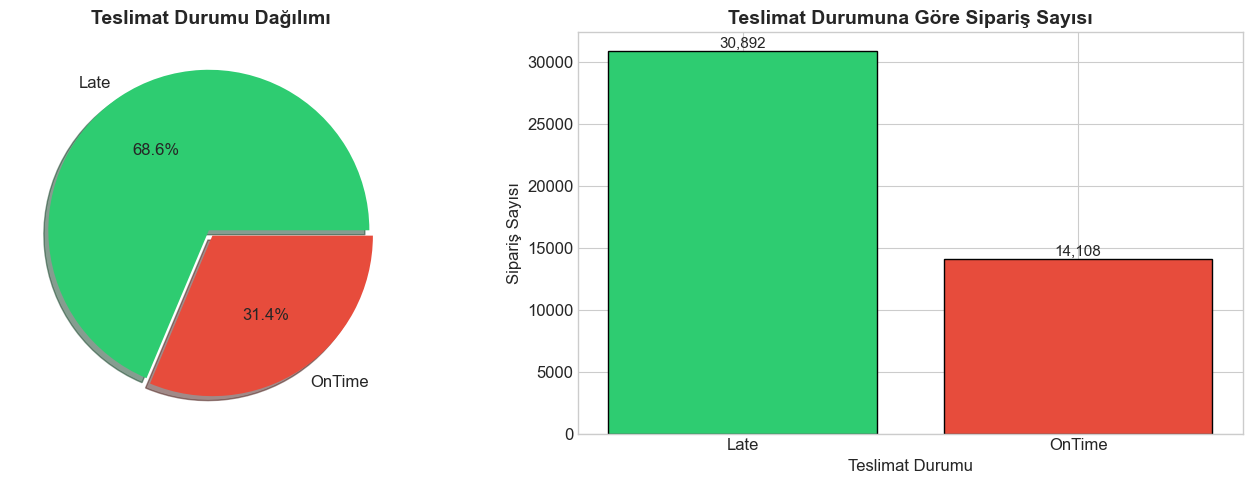

In [31]:
# Teslimat durumu pasta grafiği
if delivery_status_col:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pasta grafiği
    durum_dagilimi = df[delivery_status_col].value_counts()
    colors = ['#2ecc71', '#e74c3c'] if len(durum_dagilimi) == 2 else plt.cm.Set3.colors[:len(durum_dagilimi)]
    
    axes[0].pie(durum_dagilimi.values, labels=durum_dagilimi.index, autopct='%1.1f%%', 
                colors=colors, explode=[0.02]*len(durum_dagilimi), shadow=True)
    axes[0].set_title('Teslimat Durumu Dağılımı', fontsize=14, fontweight='bold')
    
    # Bar grafiği
    bars = axes[1].bar(durum_dagilimi.index, durum_dagilimi.values, color=colors, edgecolor='black')
    axes[1].set_xlabel('Teslimat Durumu', fontsize=12)
    axes[1].set_ylabel('Sipariş Sayısı', fontsize=12)
    axes[1].set_title('Teslimat Durumuna Göre Sipariş Sayısı', fontsize=14, fontweight='bold')
    
    # Bar üzerine değerleri yazalım
    for bar, val in zip(bars, durum_dagilimi.values):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                     f'{val:,}', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.show()

### 5.2 Kargo Firmalarına Göre Gecikme Oranları

In [32]:
# Kargo firması sütununu bulalım
carrier_col = None
for col in df.columns:
    col_lower = col.lower()
    if 'carrier' in col_lower or 'shipper' in col_lower or 'kargo' in col_lower:
        carrier_col = col
        break

if carrier_col:
    print(f"Kargo firması sütunu: {carrier_col}")
    print(f"\nKargo firmaları:")
    print(df[carrier_col].value_counts())
else:
    print("Kargo firması sütunu bulunamadı.")

Kargo firması sütunu: Carrier

Kargo firmaları:
Carrier
UPS      11346
DHL      11340
FedEx    11312
USPS     11002
Name: count, dtype: int64


Kargo Firmalarına Göre Teslimat Durumu (%)


DeliveryStatus,Late,OnTime
Carrier,,
DHL,68.86,31.14
FedEx,68.51,31.49
UPS,69.13,30.87
USPS,68.07,31.93


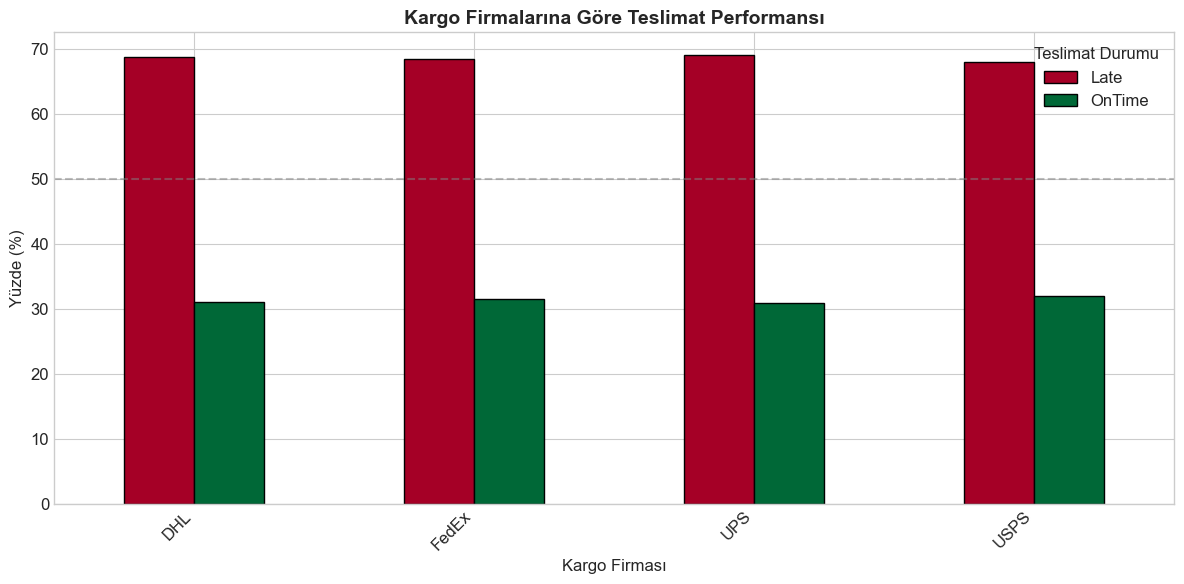

In [33]:
# Kargo firmalarına göre gecikme analizi
if carrier_col and delivery_status_col:
    # Çapraz tablo oluşturalım
    capraz_tablo = pd.crosstab(df[carrier_col], df[delivery_status_col], normalize='index') * 100
    
    print("Kargo Firmalarına Göre Teslimat Durumu (%)")
    print("=" * 50)
    display(capraz_tablo.round(2))
    
    # Görselleştirme
    fig, ax = plt.subplots(figsize=(12, 6))
    capraz_tablo.plot(kind='bar', ax=ax, colormap='RdYlGn', edgecolor='black')
    
    ax.set_xlabel('Kargo Firması', fontsize=12)
    ax.set_ylabel('Yüzde (%)', fontsize=12)
    ax.set_title('Kargo Firmalarına Göre Teslimat Performansı', fontsize=14, fontweight='bold')
    ax.legend(title='Teslimat Durumu', loc='upper right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Yüzde çizgisi
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

### 5.3 Hizmet Seviyelerine Göre Teslimat Performansı

In [34]:
# Hizmet seviyesi sütununu bulalım
service_col = None
for col in df.columns:
    col_lower = col.lower()
    if 'service' in col_lower or 'level' in col_lower or 'type' in col_lower:
        service_col = col
        break

if service_col:
    print(f"Hizmet seviyesi sütunu: {service_col}")
    print(f"\nHizmet seviyeleri:")
    print(df[service_col].value_counts())

Hizmet seviyesi sütunu: ServiceLevel

Hizmet seviyeleri:
ServiceLevel
Std          26791
Expedited    11402
Overnight     4516
BOPIS         2291
Name: count, dtype: int64


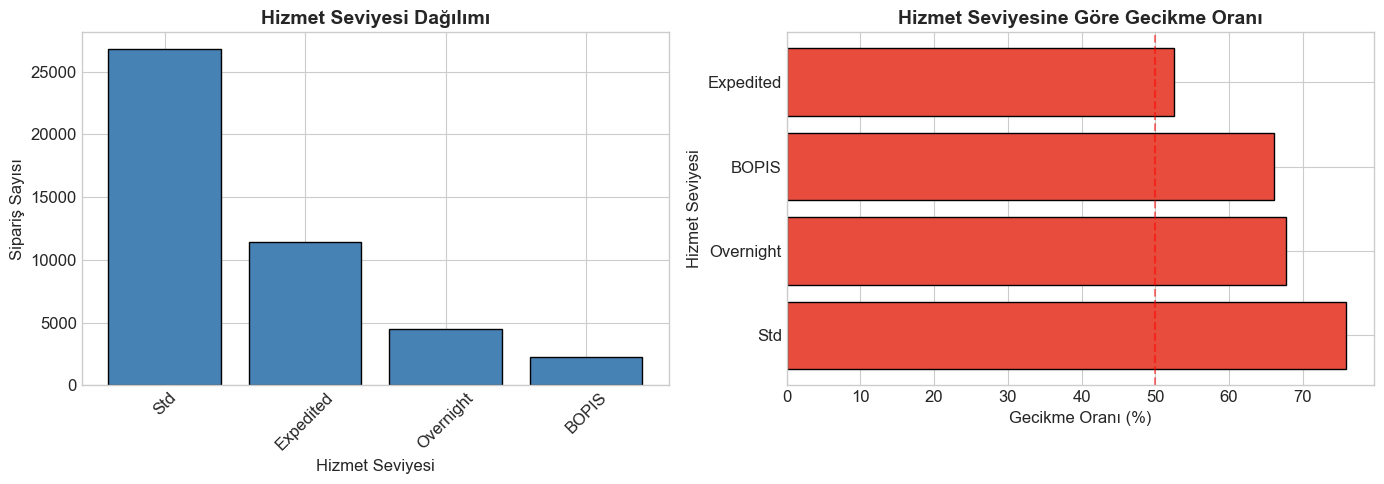

In [35]:
# Hizmet seviyesine göre teslimat performansı
if service_col and delivery_status_col:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sol: Hizmet seviyesi dağılımı
    service_counts = df[service_col].value_counts()
    axes[0].bar(service_counts.index, service_counts.values, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Hizmet Seviyesi', fontsize=12)
    axes[0].set_ylabel('Sipariş Sayısı', fontsize=12)
    axes[0].set_title('Hizmet Seviyesi Dağılımı', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Sağ: Hizmet seviyesine göre gecikme oranı
    gecikme_orani = df.groupby(service_col)[delivery_status_col].apply(
        lambda x: (x == 'Late').sum() / len(x) * 100 if 'Late' in x.values else 0
    ).sort_values(ascending=False)
    
    colors = ['#e74c3c' if val > 50 else '#f39c12' if val > 25 else '#2ecc71' for val in gecikme_orani.values]
    axes[1].barh(gecikme_orani.index, gecikme_orani.values, color=colors, edgecolor='black')
    axes[1].set_xlabel('Gecikme Oranı (%)', fontsize=12)
    axes[1].set_ylabel('Hizmet Seviyesi', fontsize=12)
    axes[1].set_title('Hizmet Seviyesine Göre Gecikme Oranı', fontsize=14, fontweight='bold')
    axes[1].axvline(x=50, color='red', linestyle='--', alpha=0.5, label='%50 eşik')
    
    plt.tight_layout()
    plt.show()

### 5.4 Zaman ve Sezon Etkilerinin İncelenmesi

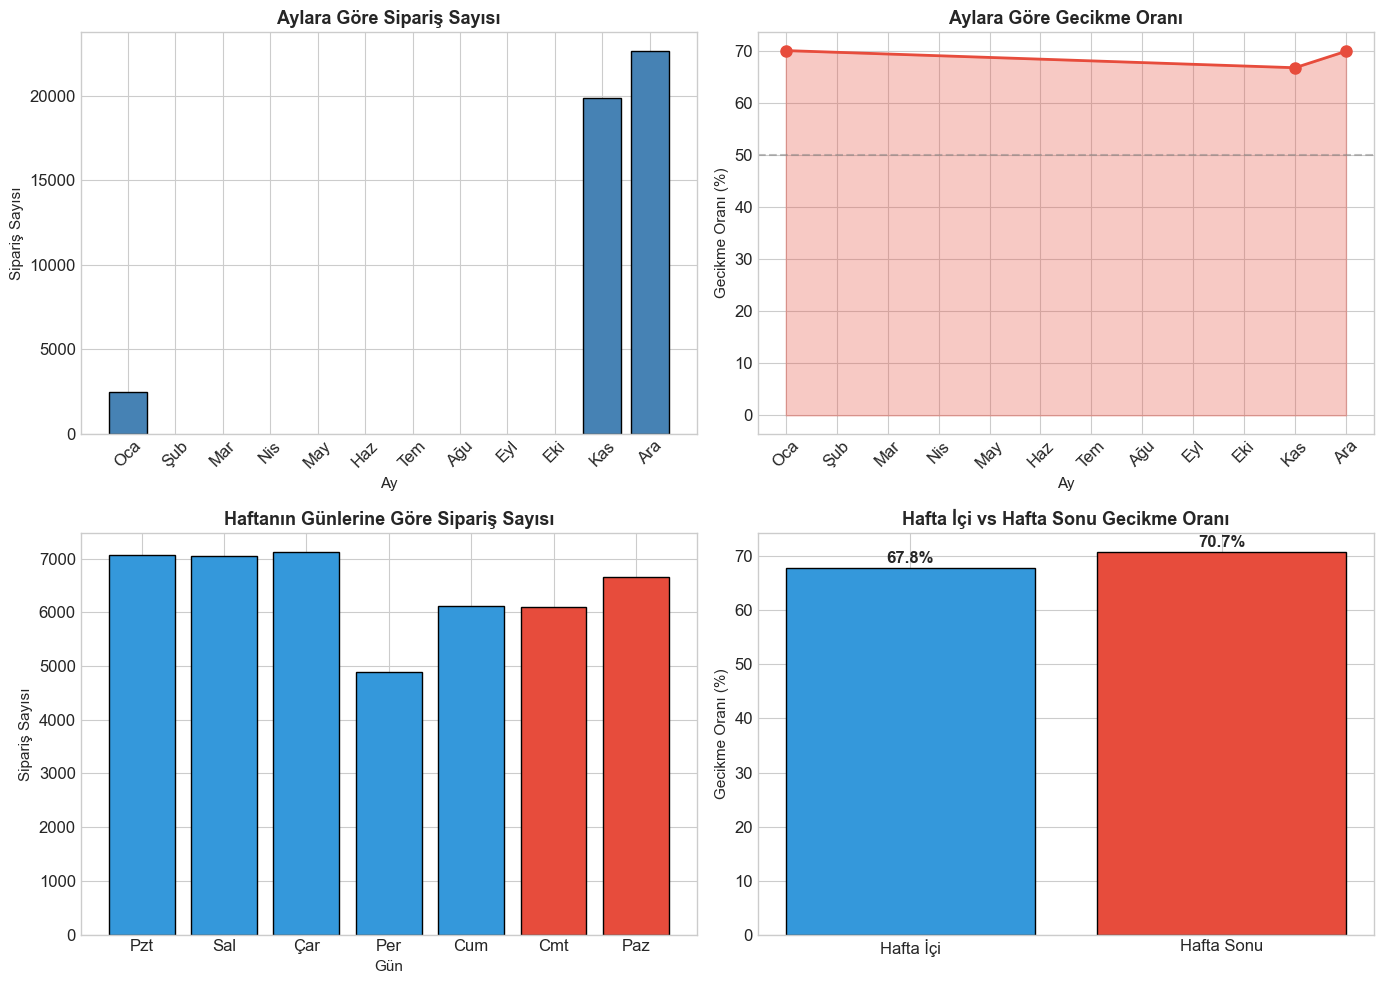

In [36]:
# Aylara göre sipariş ve gecikme analizi
if 'SevkiyatAyi' in df.columns and delivery_status_col:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Aylara göre sipariş sayısı
    ay_isimleri = ['Oca', 'Şub', 'Mar', 'Nis', 'May', 'Haz', 'Tem', 'Ağu', 'Eyl', 'Eki', 'Kas', 'Ara']
    aylik_siparis = df.groupby('SevkiyatAyi').size()
    
    axes[0, 0].bar(aylik_siparis.index, aylik_siparis.values, color='steelblue', edgecolor='black')
    axes[0, 0].set_xlabel('Ay', fontsize=11)
    axes[0, 0].set_ylabel('Sipariş Sayısı', fontsize=11)
    axes[0, 0].set_title('Aylara Göre Sipariş Sayısı', fontsize=13, fontweight='bold')
    axes[0, 0].set_xticks(range(1, 13))
    axes[0, 0].set_xticklabels(ay_isimleri, rotation=45)
    
    # 2. Aylara göre gecikme oranı
    aylik_gecikme = df.groupby('SevkiyatAyi')[delivery_status_col].apply(
        lambda x: (x == 'Late').sum() / len(x) * 100 if 'Late' in x.values else 0
    )
    
    axes[0, 1].plot(aylik_gecikme.index, aylik_gecikme.values, marker='o', linewidth=2, 
                    color='#e74c3c', markersize=8)
    axes[0, 1].fill_between(aylik_gecikme.index, aylik_gecikme.values, alpha=0.3, color='#e74c3c')
    axes[0, 1].set_xlabel('Ay', fontsize=11)
    axes[0, 1].set_ylabel('Gecikme Oranı (%)', fontsize=11)
    axes[0, 1].set_title('Aylara Göre Gecikme Oranı', fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(range(1, 13))
    axes[0, 1].set_xticklabels(ay_isimleri, rotation=45)
    axes[0, 1].axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    
    # 3. Haftanın günlerine göre sipariş
    gun_isimleri = ['Pzt', 'Sal', 'Çar', 'Per', 'Cum', 'Cmt', 'Paz']
    gunluk_siparis = df.groupby('SevkiyatGunu').size()
    
    colors = ['#3498db']*5 + ['#e74c3c']*2  # Hafta içi mavi, hafta sonu kırmızı
    axes[1, 0].bar(gunluk_siparis.index, gunluk_siparis.values, color=colors, edgecolor='black')
    axes[1, 0].set_xlabel('Gün', fontsize=11)
    axes[1, 0].set_ylabel('Sipariş Sayısı', fontsize=11)
    axes[1, 0].set_title('Haftanın Günlerine Göre Sipariş Sayısı', fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(range(7))
    axes[1, 0].set_xticklabels(gun_isimleri)
    
    # 4. Hafta sonu vs hafta içi gecikme karşılaştırması
    haftasonu_analiz = df.groupby('HaftaSonu')[delivery_status_col].apply(
        lambda x: (x == 'Late').sum() / len(x) * 100 if 'Late' in x.values else 0
    )
    
    labels = ['Hafta İçi', 'Hafta Sonu']
    colors = ['#3498db', '#e74c3c']
    axes[1, 1].bar(labels, haftasonu_analiz.values, color=colors, edgecolor='black')
    axes[1, 1].set_ylabel('Gecikme Oranı (%)', fontsize=11)
    axes[1, 1].set_title('Hafta İçi vs Hafta Sonu Gecikme Oranı', fontsize=13, fontweight='bold')
    
    for i, val in enumerate(haftasonu_analiz.values):
        axes[1, 1].text(i, val + 1, f'{val:.1f}%', ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

### 5.5 Taşıma Süresi Analizi

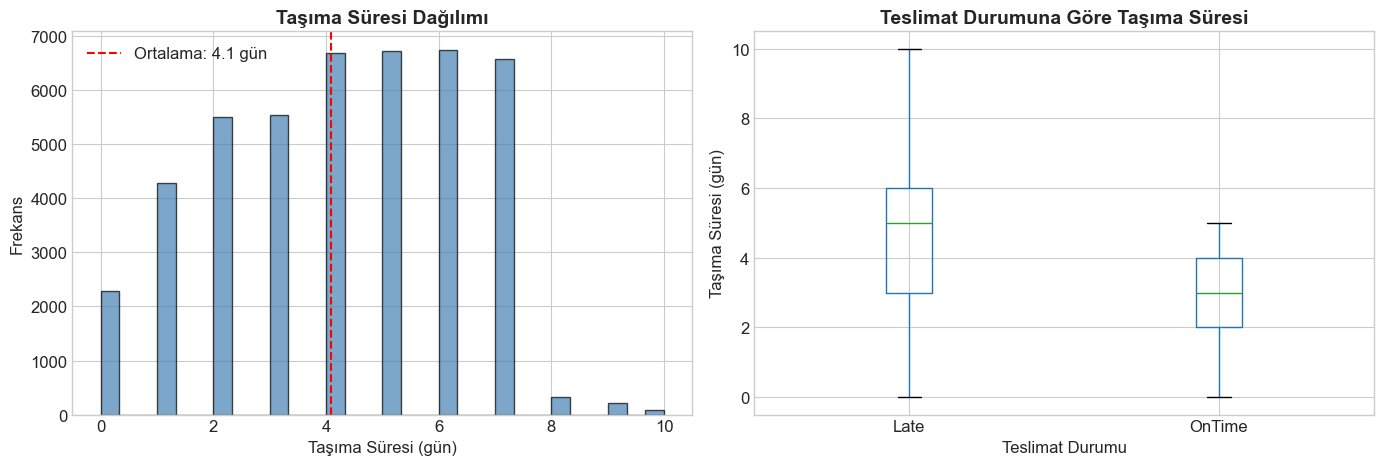

In [37]:
# Taşıma süresi dağılımı
if 'TasimaSuresi' in df.columns and delivery_status_col:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(df['TasimaSuresi'].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Taşıma Süresi (gün)', fontsize=12)
    axes[0].set_ylabel('Frekans', fontsize=12)
    axes[0].set_title('Taşıma Süresi Dağılımı', fontsize=14, fontweight='bold')
    axes[0].axvline(df['TasimaSuresi'].mean(), color='red', linestyle='--', label=f'Ortalama: {df["TasimaSuresi"].mean():.1f} gün')
    axes[0].legend()
    
    # Teslimat durumuna göre boxplot
    df.boxplot(column='TasimaSuresi', by=delivery_status_col, ax=axes[1])
    axes[1].set_xlabel('Teslimat Durumu', fontsize=12)
    axes[1].set_ylabel('Taşıma Süresi (gün)', fontsize=12)
    axes[1].set_title('Teslimat Durumuna Göre Taşıma Süresi', fontsize=14, fontweight='bold')
    plt.suptitle('')  # Pandas'ın otomatik başlığını kaldır
    
    plt.tight_layout()
    plt.show()

### 5.6 Korelasyon Analizi

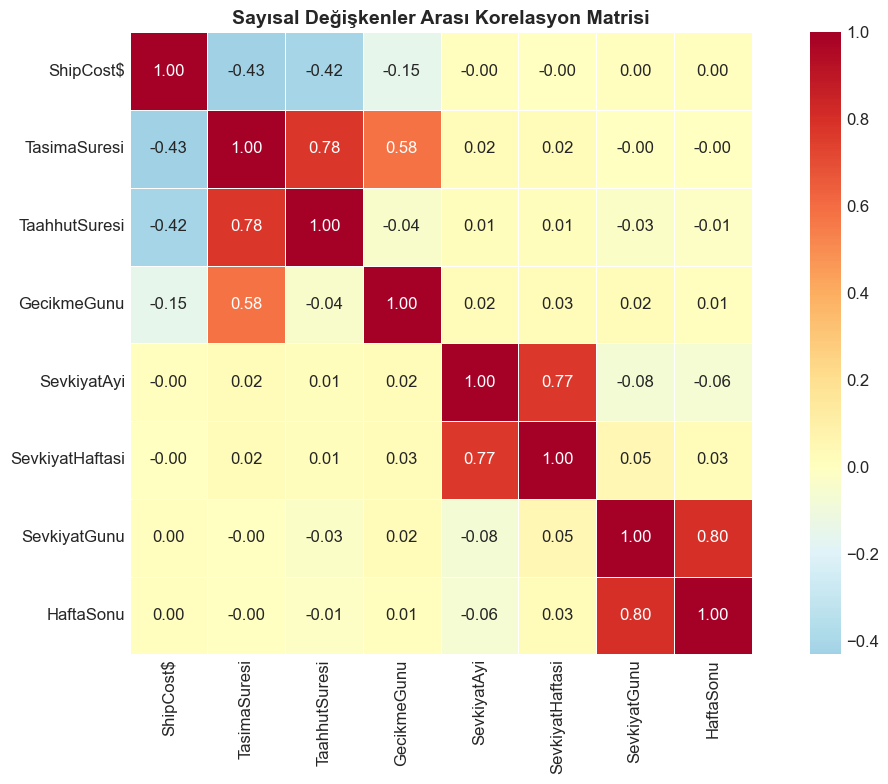

In [38]:
# Sayısal değişkenler arasındaki korelasyon
sayisal_sutunlar = df.select_dtypes(include=[np.number]).columns.tolist()

# ID sütunlarını çıkaralım
sayisal_sutunlar = [col for col in sayisal_sutunlar if 'ID' not in col and 'Id' not in col]

if len(sayisal_sutunlar) > 1:
    korelasyon = df[sayisal_sutunlar].corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(korelasyon, annot=True, cmap='RdYlBu_r', center=0, 
                fmt='.2f', square=True, linewidths=0.5)
    plt.title('Sayısal Değişkenler Arası Korelasyon Matrisi', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

---

## 6. Makine Öğrenmesi

### 6.1 Problem Tanımı

**Problem Türü:** İkili Sınıflandırma (Binary Classification)

**Hedef Değişken:** DeliveryStatus (Late / OnTime)

**Amaç:** Bir siparişin teslimatının geç olup olmayacağını tahmin etmek.

### 6.2 Veri Hazırlığı

In [39]:
# Hedef değişkeni belirleyelim
if delivery_status_col:
    print(f"Hedef değişken: {delivery_status_col}")
    print(f"\nHedef değişken dağılımı:")
    print(df[delivery_status_col].value_counts())
    
    # Hedef değişkeni sayısala çevirelim (Late=1, OnTime=0)
    df['HedefDegisken'] = (df[delivery_status_col] == 'Late').astype(int)
    print(f"\nSayısallaştırılmış hedef değişken:")
    print(df['HedefDegisken'].value_counts())

Hedef değişken: DeliveryStatus

Hedef değişken dağılımı:
DeliveryStatus
Late      30892
OnTime    14108
Name: count, dtype: int64

Sayısallaştırılmış hedef değişken:
HedefDegisken
1    30892
0    14108
Name: count, dtype: int64


In [40]:
# Model için kullanılacak özellikleri seçelim
# ID sütunlarını ve tarih sütunlarını çıkaralım

# Potansiyel özellik sütunları
ozellik_adaylari = []

for col in df.columns:
    # ID ve tarih sütunlarını atla
    if 'ID' in col or 'Id' in col or 'id' in col:
        continue
    if 'Date' in col or 'date' in col:
        continue
    if col == delivery_status_col or col == 'HedefDegisken':
        continue
    
    ozellik_adaylari.append(col)

print("Potansiyel özellik sütunları:")
for i, col in enumerate(ozellik_adaylari, 1):
    print(f"{i:2}. {col} - Tip: {df[col].dtype}")

Potansiyel özellik sütunları:
 1. Carrier - Tip: object
 2. ServiceLevel - Tip: object
 3. ShipCost$ - Tip: float64
 4. CouponCode - Tip: object
 5. PaymentType - Tip: object
 6. TasimaSuresi - Tip: int64
 7. TaahhutSuresi - Tip: int64
 8. GecikmeGunu - Tip: int64
 9. SevkiyatAyi - Tip: int32
10. SevkiyatHaftasi - Tip: UInt32
11. SevkiyatGunu - Tip: int32
12. HaftaSonu - Tip: int64


In [41]:
# Kategorik değişkenleri sayısallaştıralım
from sklearn.preprocessing import LabelEncoder

# Model için kullanılacak DataFrame'i oluşturalım
df_model = df.copy()

# Kategorik sütunları tespit edelim
kategorik_sutunlar = df_model[ozellik_adaylari].select_dtypes(include=['object']).columns.tolist()
print(f"Kategorik sütunlar: {kategorik_sutunlar}")

# Label Encoding uygulayalım
label_encoders = {}
for col in kategorik_sutunlar:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"'{col}' sütunu encode edildi. Sınıflar: {le.classes_}")

Kategorik sütunlar: ['Carrier', 'ServiceLevel', 'CouponCode', 'PaymentType']
'Carrier' sütunu encode edildi. Sınıflar: ['DHL' 'FedEx' 'UPS' 'USPS']
'ServiceLevel' sütunu encode edildi. Sınıflar: ['BOPIS' 'Expedited' 'Overnight' 'Std']
'CouponCode' sütunu encode edildi. Sınıflar: ['BF25' 'CM20' 'HOLIDAY15' 'SAVE10' 'nan']
'PaymentType' sütunu encode edildi. Sınıflar: ['BNPL' 'Card' 'Cash' 'PayPal']


In [42]:
# Final özellik setini oluşturalım
# Sayısal özellikler + encode edilmiş kategorik özellikler

sayisal_ozellikler = []
for col in ozellik_adaylari:
    if df_model[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        sayisal_ozellikler.append(col)

encoded_ozellikler = [col + '_encoded' for col in kategorik_sutunlar]

final_ozellikler = sayisal_ozellikler + encoded_ozellikler

print("Model için kullanılacak özellikler:")
print("-" * 40)
for i, col in enumerate(final_ozellikler, 1):
    print(f"{i:2}. {col}")

Model için kullanılacak özellikler:
----------------------------------------
 1. ShipCost$
 2. TasimaSuresi
 3. TaahhutSuresi
 4. GecikmeGunu
 5. SevkiyatAyi
 6. SevkiyatGunu
 7. HaftaSonu
 8. Carrier_encoded
 9. ServiceLevel_encoded
10. CouponCode_encoded
11. PaymentType_encoded


In [43]:
# X (özellikler) ve y (hedef) değişkenlerini ayıralım
X = df_model[final_ozellikler].copy()
y = df_model['HedefDegisken'].copy()

# Eksik değerleri dolduralım
X = X.fillna(X.median())

print(f"X (Özellikler) boyutu: {X.shape}")
print(f"y (Hedef) boyutu: {y.shape}")
print(f"\nHedef değişken dağılımı:")
print(y.value_counts())

X (Özellikler) boyutu: (45000, 11)
y (Hedef) boyutu: (45000,)

Hedef değişken dağılımı:
HedefDegisken
1    30892
0    14108
Name: count, dtype: int64


### 6.3 Eğitim ve Test Setlerinin Oluşturulması

In [44]:
# Veriyi eğitim (%80) ve test (%20) olarak ayıralım
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20,  # %20 test seti
    random_state=42,  # Tekrarlanabilirlik için
    stratify=y  # Sınıf dengesini korumak için
)

print("Veri Seti Bölümleme")
print("=" * 40)
print(f"Eğitim seti boyutu: {X_train.shape[0]} örnek")
print(f"Test seti boyutu: {X_test.shape[0]} örnek")
print(f"\nEğitim seti hedef dağılımı:")
print(y_train.value_counts())
print(f"\nTest seti hedef dağılımı:")
print(y_test.value_counts())

Veri Seti Bölümleme
Eğitim seti boyutu: 36000 örnek
Test seti boyutu: 9000 örnek

Eğitim seti hedef dağılımı:
HedefDegisken
1    24714
0    11286
Name: count, dtype: int64

Test seti hedef dağılımı:
HedefDegisken
1    6178
0    2822
Name: count, dtype: int64


### 6.4 Model Kurulumu - Lojistik Regresyon

In [45]:
# Lojistik Regresyon modeli oluşturalım
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Modeli eğitelim
log_reg.fit(X_train, y_train)

# Tahmin yapalım
y_pred_log = log_reg.predict(X_test)

print("Lojistik Regresyon modeli eğitildi!")

Lojistik Regresyon modeli eğitildi!


### 6.5 Model Kurulumu - Karar Ağacı

In [46]:
# Karar Ağacı modeli oluşturalım
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Modeli eğitelim
dt_model.fit(X_train, y_train)

# Tahmin yapalım
y_pred_dt = dt_model.predict(X_test)

print("Karar Ağacı modeli eğitildi!")

Karar Ağacı modeli eğitildi!


---

## 7. Model Değerlendirme

### 7.1 Accuracy (Doğruluk) Metriği

In [47]:
# Her iki modelin doğruluk skorları
acc_log = accuracy_score(y_test, y_pred_log)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("Model Doğruluk Skorları")
print("=" * 40)
print(f"Lojistik Regresyon: {acc_log:.4f} ({acc_log*100:.2f}%)")
print(f"Karar Ağacı: {acc_dt:.4f} ({acc_dt*100:.2f}%)")

Model Doğruluk Skorları
Lojistik Regresyon: 1.0000 (100.00%)
Karar Ağacı: 1.0000 (100.00%)


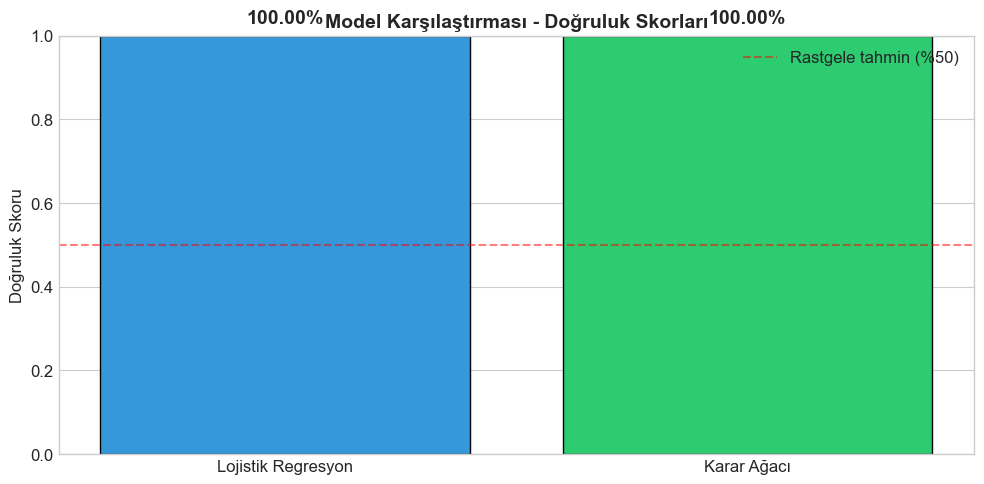

In [48]:
# Doğruluk skorlarını görselleştirelim
modeller = ['Lojistik Regresyon', 'Karar Ağacı']
skorlar = [acc_log, acc_dt]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(modeller, skorlar, color=['#3498db', '#2ecc71'], edgecolor='black')

ax.set_ylabel('Doğruluk Skoru', fontsize=12)
ax.set_title('Model Karşılaştırması - Doğruluk Skorları', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)

# Bar üzerine değerleri yazalım
for bar, skor in zip(bars, skorlar):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{skor*100:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Referans çizgisi
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Rastgele tahmin (%50)')
ax.legend()

plt.tight_layout()
plt.show()

### 7.2 Confusion Matrix (Karışıklık Matrisi)

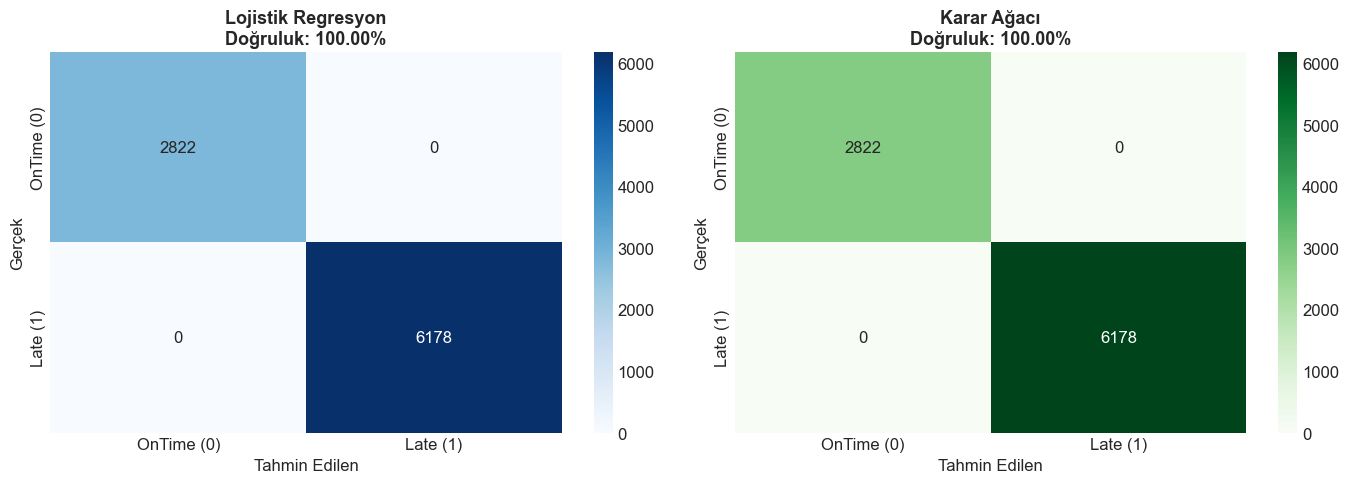

In [49]:
# Her iki model için confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lojistik Regresyon
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['OnTime (0)', 'Late (1)'],
            yticklabels=['OnTime (0)', 'Late (1)'])
axes[0].set_xlabel('Tahmin Edilen', fontsize=12)
axes[0].set_ylabel('Gerçek', fontsize=12)
axes[0].set_title(f'Lojistik Regresyon\nDoğruluk: {acc_log*100:.2f}%', fontsize=13, fontweight='bold')

# Karar Ağacı
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['OnTime (0)', 'Late (1)'],
            yticklabels=['OnTime (0)', 'Late (1)'])
axes[1].set_xlabel('Tahmin Edilen', fontsize=12)
axes[1].set_ylabel('Gerçek', fontsize=12)
axes[1].set_title(f'Karar Ağacı\nDoğruluk: {acc_dt*100:.2f}%', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

### 7.3 Detaylı Sınıflandırma Raporu

In [50]:
# Lojistik Regresyon için sınıflandırma raporu
print("LOJİSTİK REGRESYON - Sınıflandırma Raporu")
print("=" * 55)
print(classification_report(y_test, y_pred_log, target_names=['OnTime', 'Late']))

LOJİSTİK REGRESYON - Sınıflandırma Raporu
              precision    recall  f1-score   support

      OnTime       1.00      1.00      1.00      2822
        Late       1.00      1.00      1.00      6178

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000



In [51]:
# Karar Ağacı için sınıflandırma raporu
print("KARAR AĞACI - Sınıflandırma Raporu")
print("=" * 55)
print(classification_report(y_test, y_pred_dt, target_names=['OnTime', 'Late']))

KARAR AĞACI - Sınıflandırma Raporu
              precision    recall  f1-score   support

      OnTime       1.00      1.00      1.00      2822
        Late       1.00      1.00      1.00      6178

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000



### 7.4 Özellik Önemliliği (Feature Importance)

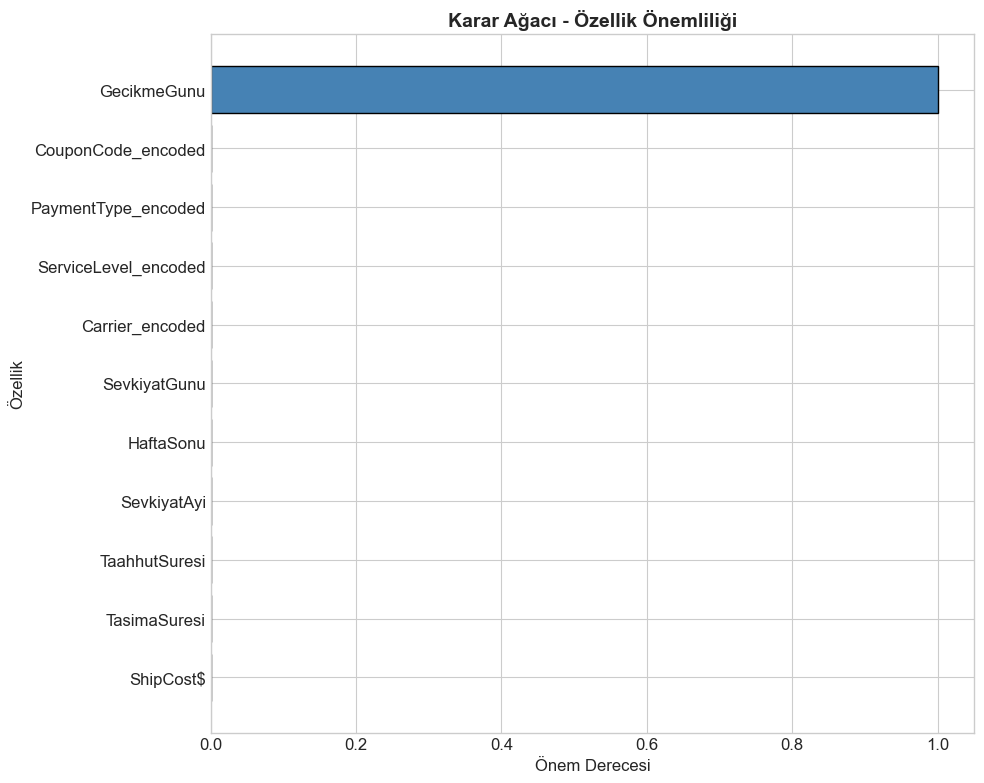


En önemli 5 özellik:
             Ozellik  Onem
     Carrier_encoded   0.0
ServiceLevel_encoded   0.0
 PaymentType_encoded   0.0
  CouponCode_encoded   0.0
         GecikmeGunu   1.0


In [52]:
# Karar Ağacı modelinin özellik önemliliği
ozellik_onemliligi = pd.DataFrame({
    'Ozellik': final_ozellikler,
    'Onem': dt_model.feature_importances_
}).sort_values('Onem', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(ozellik_onemliligi['Ozellik'], ozellik_onemliligi['Onem'], color='steelblue', edgecolor='black')
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
plt.title('Karar Ağacı - Özellik Önemliliği', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nEn önemli 5 özellik:")
print(ozellik_onemliligi.tail().to_string(index=False))

---

## 8. Sonuç ve Yorum

### 8.1 Model Performansının Değerlendirilmesi

In [53]:
# Sonuç özeti
print("="*70)
print("                    SONUÇ ÖZETİ                    ")
print("="*70)
print(f"""
1. VERİ SETİ
   - Toplam kayıt sayısı: {len(df):,}
   - Kullanılan özellik sayısı: {len(final_ozellikler)}
   - Eğitim seti: {len(X_train):,} örnek
   - Test seti: {len(X_test):,} örnek

2. MODEL PERFORMANSLARI
   - Lojistik Regresyon Doğruluğu: {acc_log*100:.2f}%
   - Karar Ağacı Doğruluğu: {acc_dt*100:.2f}%
   
3. EN İYİ MODEL: {'Lojistik Regresyon' if acc_log > acc_dt else 'Karar Ağacı'}
   - Doğruluk: {max(acc_log, acc_dt)*100:.2f}%
""")
print("="*70)

                    SONUÇ ÖZETİ                    

1. VERİ SETİ
   - Toplam kayıt sayısı: 45,000
   - Kullanılan özellik sayısı: 11
   - Eğitim seti: 36,000 örnek
   - Test seti: 9,000 örnek

2. MODEL PERFORMANSLARI
   - Lojistik Regresyon Doğruluğu: 100.00%
   - Karar Ağacı Doğruluğu: 100.00%
   
3. EN İYİ MODEL: Karar Ağacı
   - Doğruluk: 100.00%



### 8.2 Teslimat Gecikmesini Etkileyen Faktörler

In [54]:
# En önemli faktörlerin yorumu
print("Teslimat Gecikmesini Etkileyen Temel Faktörler")
print("="*55)

en_onemli = ozellik_onemliligi.tail(5).iloc[::-1]
for i, (_, row) in enumerate(en_onemli.iterrows(), 1):
    print(f"{i}. {row['Ozellik']}: {row['Onem']*100:.2f}% önem")

Teslimat Gecikmesini Etkileyen Temel Faktörler
1. GecikmeGunu: 100.00% önem
2. CouponCode_encoded: 0.00% önem
3. PaymentType_encoded: 0.00% önem
4. ServiceLevel_encoded: 0.00% önem
5. Carrier_encoded: 0.00% önem


### 8.3 Veri Setinin Güçlü ve Sınırlı Yönleri

**Güçlü Yönler:**
- Çoklu tablo yapısı sayesinde kapsamlı bir e-ticaret senaryosu sunması
- Black Friday, Cyber Monday ve Noel gibi yoğun dönemleri içermesi
- Teslimat, iade ve kampanya bilgilerinin bir arada bulunması
- Gerçekçi lojistik verileri içermesi

**Sınırlı Yönler:**
- Coğrafi bilgilerin (mesafe, bölge) sınırlı olması
- Hava durumu gibi dış faktörlerin bulunmaması
- Müşteri davranış verilerinin eksikliği

---

## Kaynaklar

- Veri Seti: Kaggle - Christmas Retail Sales – Shipping & Delivery Dataset
- Python Kütüphaneleri: pandas, numpy, matplotlib, seaborn, scikit-learn

---

*Bu notebook, Veri Bilimine Giriş ve Makine Öğrenmesi dersi kapsamında hazırlanmıştır.*